In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Data preparation

In [2]:
df = pd.read_csv('data/car_fuel_efficiency.csv')
# display(df)

df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [3]:
target = 'fuel_efficiency_mpg'

## Fill missing values with zeros

In [4]:
df.isna().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [5]:
df[df.isna()] = 0

In [6]:
df.isna().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

## Train-test split

- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.

In [7]:
from sklearn.model_selection import train_test_split

seed = 1

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=seed)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=seed)

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]

for dat in [df_train, df_val, df_test]:
    dat.drop(columns=target, inplace=True)

In [8]:
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

from sklearn.feature_extraction import DictVectorizer

dicts_f = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
dv.fit(dicts_f)

def turn_to_matrix(df):
    dicts_df = df.to_dict(orient='records')
    return dv.transform(dicts_df)

X_train = turn_to_matrix(df_train)
X_val = turn_to_matrix(df_val)
X_test = turn_to_matrix(df_test)

# Question 1

In [9]:
# Train a model with max_depth=1

from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=1)

model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [10]:
from sklearn.tree import export_text

print(export_text(model, feature_names=dv.get_feature_names_out()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



# Question 2

In [11]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [12]:
from sklearn.metrics import root_mean_squared_error

y_pred = model.predict(X_val)

root_mean_squared_error(y_val, y_pred)

0.4595777223092726

# Question 3

10:	0.460	0.45958
20:	0.454	0.45359
30:	0.452	0.45169
40:	0.449	0.44872
50:	0.447	0.44666
60:	0.445	0.44546
70:	0.445	0.44513
80:	0.445	0.44498
90:	0.445	0.44486
100:	0.445	0.44465
110:	0.444	0.44358
120:	0.444	0.44391
130:	0.444	0.44370
140:	0.443	0.44335
150:	0.443	0.44290
160:	0.443	0.44276
170:	0.443	0.44280
180:	0.442	0.44236
190:	0.442	0.44249
200:	0.442	0.44248
210:	0.442	0.44245
220:	0.443	0.44251
230:	0.442	0.44234
240:	0.442	0.44237


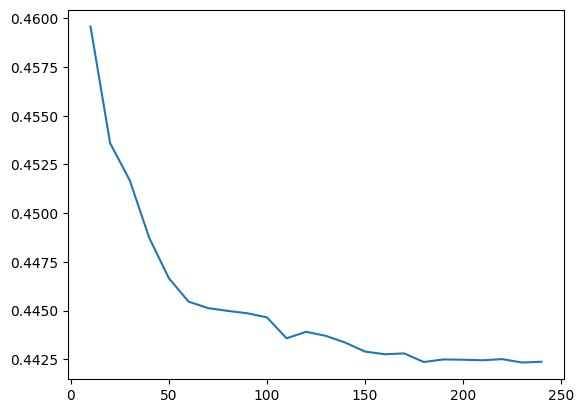

In [13]:
def eval(n_estimators):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return root_mean_squared_error(y_val, y_pred)

scores = []
for n_estimators in range(10, 250, 10):
    score = eval(n_estimators)
    print(f'{n_estimators}:\t{score:.3f}\t{score:.5f}')
    scores.append((n_estimators, score))

scores = pd.DataFrame(scores, columns=['n_est', 'score'])

plt.plot(scores.n_est, scores.score);

# Question 4

In [14]:
def eval(**params):
    model = RandomForestRegressor(random_state=1, n_jobs=-1, **params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return root_mean_squared_error(y_val, y_pred)

for max_depth in [10, 15, 20, 25]:
    scores = []
    for n_estimators in range(10, 210, 10):
        score = eval(n_estimators=n_estimators, max_depth=max_depth)
        scores.append(score)
    
    print(scores)
    mean_score = np.mean(scores)
    print(f'{max_depth=}:\t{mean_score:.3f}\t{mean_score:.5f}')

[0.45024865970585237, 0.4468570336292019, 0.44547396459413735, 0.44306731129625837, 0.4419566862179357, 0.4416730330613032, 0.44129755036940715, 0.44143523500728943, 0.4415215165581006, 0.4412169979071018, 0.4405262272478249, 0.4407083659646053, 0.440629500094825, 0.44033941277349, 0.43994270355172627, 0.4397974050383318, 0.4400174394744502, 0.43974886968170657, 0.43985420021815075, 0.43984510625501455]
max_depth=10:	0.442	0.44181
[0.4576238478625812, 0.4530718735379796, 0.4508686966214543, 0.44860934889795906, 0.4463180769184866, 0.44529206075521127, 0.44460570044941033, 0.4445668530498767, 0.4445762190052127, 0.44434108308741715, 0.44347884734275095, 0.44373414652134413, 0.4435457361621003, 0.4431627041644266, 0.4427315468888105, 0.44250726673675567, 0.44255661607337693, 0.44206061032158245, 0.44233607206578385, 0.4423455848136943]
max_depth=15:	0.445	0.44542
[0.45873868286340574, 0.45402938825821765, 0.4519817374335399, 0.4493145647994632, 0.44731243215557775, 0.44613303654630015, 0

# Question 5

In [15]:
params = dict(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1)
model = RandomForestRegressor(**params)
model.fit(X_train, y_train)
model.feature_importances_

array([1.14797006e-02, 3.57108549e-04, 3.45384113e-04, 3.27279191e-03,
       3.25424323e-04, 3.60383601e-04, 1.59978977e-02, 3.21230009e-03,
       2.34334695e-03, 1.63498954e-03, 4.62246496e-04, 5.18739639e-04,
       5.39721689e-04, 9.59149965e-01])

In [16]:
for name, imp in zip(dv.get_feature_names_out(), model.feature_importances_):
    print(f'{name}:\t{imp:.3f}')

acceleration:	0.011
drivetrain=All-wheel drive:	0.000
drivetrain=Front-wheel drive:	0.000
engine_displacement:	0.003
fuel_type=Diesel:	0.000
fuel_type=Gasoline:	0.000
horsepower:	0.016
model_year:	0.003
num_cylinders:	0.002
num_doors:	0.002
origin=Asia:	0.000
origin=Europe:	0.001
origin=USA:	0.001
vehicle_weight:	0.959


In [17]:
i = np.argmax(model.feature_importances_)

dv.get_feature_names_out()[i]

'vehicle_weight'

# Question 6

In [18]:
import xgboost as xgb

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

features = dv.get_feature_names_out().tolist()

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [19]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [20]:
%%capture output

model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100)
y_pred = model.predict(dval)

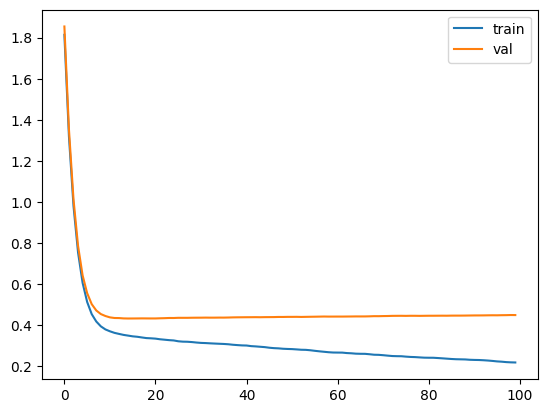

In [21]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_metric', 'val_metric']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

df_score = parse_xgb_output(output)

plt.plot(df_score.num_iter, df_score.train_metric, label='train')
plt.plot(df_score.num_iter, df_score.val_metric, label='val')
plt.legend();

In [22]:
root_mean_squared_error(y_val, y_pred)

0.45017755678087246

In [23]:
%%capture output

xgb_params['eta'] = 0.1

model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100)
y_pred = model.predict(dval)

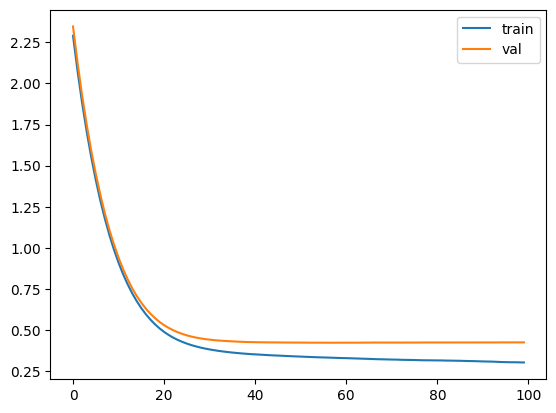

In [24]:
df_score = parse_xgb_output(output)

plt.plot(df_score.num_iter, df_score.train_metric, label='train')
plt.plot(df_score.num_iter, df_score.val_metric, label='val')
plt.legend();

In [25]:
root_mean_squared_error(y_val, y_pred)

0.42622800553359225

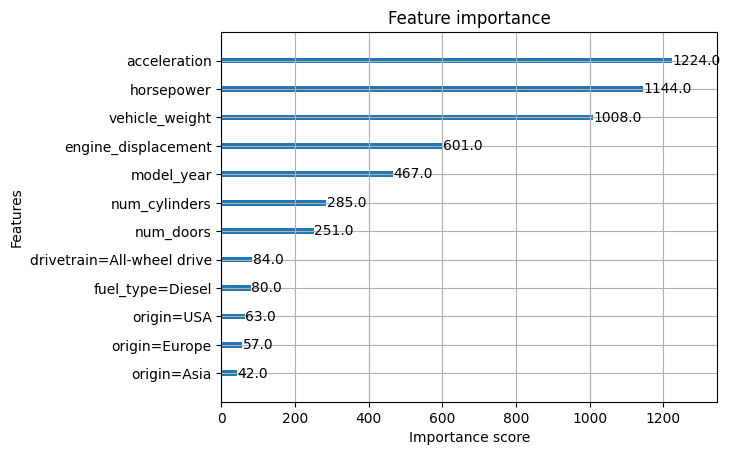

In [26]:
xgb.plot_importance(model);